### Fire history
First lets ge the MTBS data and beat that into shape. Data for he Trinity and South Fork Trinity basins was selected using the MTBS interactive viewer ([https://www.mtbs.gov/viewer/index.html](https://www.mtbs.gov/viewer/index.html)) on 2023-10-17 At about 10:38 a.m. After recieving the download link the zipped data was downloaded using wget to `/media/storage/MTBS/Trinity_and_S_Trinity` directory and unzipped resulting in a directory, `mtbs`, full of directories for years ranging from  1985 and 2021.  Within the directory for a given year there are boundaries and burn indices for each fire attributed to that year. 

In [30]:
from datetime import datetime
from pathlib import Path
import os
from joblib import Parallel, delayed
from itertools import combinations

import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union, cascaded_union
from shapely.geometry import Polygon, MultiPolygon
import xarray as xr
import rioxarray

import warnings
warnings.filterwarnings('ignore')

We will only look at the fires within the trinity river basin

In [2]:
# path to trinity data within project
trinity_dir = Path('/home/michael/TreeMortality/trinity')

# Trinity River basin as AOI
aoi_path = Path('/media/storage/TrinityCounty/Trinity_county_boundary_26910.gpkg')
aoi = gpd.read_file(aoi_path)
aoi_poly = aoi.geometry.values[0]

# get crs (26910)
crs = aoi.crs

# path to root dir of fire data
mtbs_dir = Path('/media/storage/MTBS/Trinity_and_S_Trinity/mtbs/')

In [3]:
# glob needed files
boundary_files = mtbs_dir.rglob('*_burn_bndy.shp')
burn_files = list(mtbs_dir.rglob('*_dnbr.tif'))

# read all shapes intersecting AOI into gdf, and associate dnbr tifs
df_list = []
for bound_path in boundary_files:
    df = gpd.read_file(bound_path).to_crs(crs)
    if df.geometry.intersects(aoi)[0]:
        event_id, pre_date, post_date, _, _ = bound_path.stem.split('_')
        df['tif_path'] = [str(tif) for tif in burn_files if event_id in str(tif)][0]
        df['pre_date'], df['post_date'] = pre_date, post_date
        df_list.append(df)


fires = pd.concat(df_list)


In [4]:
fires.head(2)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry,tif_path,pre_date,post_date
0,CA4079212335020120711,NaN,FLAT,Wildfire,829,MTBS,Extended,1833,40.792,-123.335,...,-970,-150,100,332,600,NaN,"POLYGON ((471448.099 4517290.303, 471465.694 4...",/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...,20110723,20130712
0,CA4054612309020120905,NaN,STAFFORD,Wildfire,839,MTBS,Extended,4509,40.541,-123.107,...,-970,-150,120,328,580,NaN,"POLYGON ((489114.061 4485768.818, 489099.707 4...",/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...,20110723,20130712


In [85]:
fires.tif_path.head(2)

0    /media/storage/MTBS/Trinity_and_S_Trinity/mtbs...
0    /media/storage/MTBS/Trinity_and_S_Trinity/mtbs...
Name: tif_path, dtype: object

In [5]:
# save as geoparquet
parq_path = mtbs_dir / 'trinity_county_fires_1885-2021.parquet'
fires.to_parquet(parq_path)

In [84]:
basin_path = Path('/media/storage/watershed_boundaries/trinity_huc18010211_26910.geojson')
basin = gpd.read_file(basin_path)
basin_poly = basin.geometry.values[0]

basin_fires = gpd.clip(fires, basin_poly)
print(f'all fires: {len(fires)}\nbasin fires: {len(basin_fires)}')
basin_fires.head(2)

all fires: 44
basin fires: 31


,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry,tif_path,pre_date,post_date
0,CA4068012335620150731,B09ECB62-6483-4F8A-9943-99863E39FA5D,PATTISON,Wildfire,25329,MTBS,Extended,30757,40.686,-123.416,...,-970,-150,50,275,530,This fire part of SOUTH COMPLEX and contains M...,"POLYGON ((459201.777 4510449.686, 459219.958 4...",/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...,20140706,20160711
0,CA4054612266320080621,NaN,SHU LIGHTNING COMPLEX (MOON),Wildfire,16596,MTBS,Extended,36513,40.556,-122.68,...,-970,-150,100,331,600,NaN,"MULTIPOLYGON (((520674.949 4489417.087, 520710...",/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...,20070712,20090717


In [11]:
# save as geojnon
json_path = trinity_dir / 'fires' / 'trinity_basin_fires_1885-2021.geojson'
os.makedirs(json_path.parent, exist_ok=True)
basin_fires.to_file(json_path)

In [104]:
def intersection_operation(row1, row2, min_area):
    '''computes intersection of two polygons if area is above given threshold.'''
    intersection = row1.geometry.intersection(row2.geometry)
    if intersection.is_empty or intersection.area <= min_area:
        return None
    years = {int(row1.post_date[:4]), int(row2.post_date[:4])}
    tif_paths = [row1.tif_path, row2.tif_path]
    
    return {'geometry': intersection, 'years': years, 'tif_paths': tif_paths}

def make_history(gdf, min_area):
    '''creates GeoDataFrame with intersections of polygons larger than specified area, 
    including list of years.

    parameters:
    gdf (GeoDataFrame): input GeoDataFrame with polygon geometries and 'post_date' column.
    min_area (float): minimum area threshold for intersections.

    returns:
    GeoDataFrame: GeoDataFrame containing intersections with area larger than min_area 
                  and list of years for each.
    '''
    # prepare pairs of polygons to process in parallel for intersections
    pairs = combinations(range(len(gdf)), 2)

    # parallel computation of intersections
    intersection_results = Parallel(n_jobs=-1)(
        delayed(intersection_operation)(
            gdf.iloc[i], gdf.iloc[j], min_area
        ) for i, j in pairs
    )

    # combine and filter out None results
    combined_results = [res for res in intersection_results if res]

    # create new GeoDataFrame from combined results
    fire_history = gpd.GeoDataFrame(combined_results, 
                                    columns=['geometry', 'years', 'tif_paths'])

    # convert 'years' list to a tuple to make it hashable for dissolve
    fire_history['years'] = fire_history['years'].apply(tuple)

    # dissolve overlapping polygons using the unique identifier
    dissolved = fire_history.dissolve(by='years', aggfunc='first')

    # reset the index to remove the 'years' tuples
    dissolved.reset_index(inplace=True)

    return dissolved


# find intersections larger than 1 ha
min_area = 10_000
multi_burns = make_history(basin_fires, min_area)

In [106]:
def difference_operation(base_row, other_rows, min_area):
    '''computes difference of base polygon from union of all other polygons.'''
    base_poly = base_row.geometry
    other_polys = unary_union([row.geometry for row in other_rows])
    difference = base_poly.difference(other_polys)
    if difference.is_empty or difference.area <= min_area:
        return None
    return {
        'geometry': difference,
        'years': int(base_row.post_date[:4]),
        'tif_paths': (base_row.tif_path)}


def make_difference_history(gdf, min_area):
    '''creates GeoDataFrame with differences of each polygon from all others
    larger than specified area, including the year.

    parameters:
    gdf (GeoDataFrame): input GeoDataFrame with polygon geometries and 'post_date' column.
    min_area (float): minimum area threshold for differences.

    returns:
    GeoDataFrame: GeoDataFrame containing differences with area larger than min_area 
                  and the year for each.
    '''
    # create a list of all other rows for each row to process in parallel for differences
    all_rows = list(gdf.itertuples(index=False))

    # parallel computation of differences
    difference_results = Parallel(n_jobs=-1)(
        delayed(difference_operation)(
            base_row, [other_row for other_row in all_rows if other_row != base_row], min_area
        ) for base_row in all_rows
    )

    # combine and filter out None results
    combined_results = [res for res in difference_results if res]

    # create new GeoDataFrame from combined results
    difference_history = gpd.GeoDataFrame(combined_results, 
                                          columns=['geometry', 'years', 'tif_paths'])

    return difference_history

# example usage:
single_burns = make_difference_history(basin_fires, min_area)


In [131]:
fire_history = pd.concat([single_burns, multi_burns])
fire_history.iloc[[0, 1, -2, -1]]

,geometry,years,tif_paths
0,"POLYGON ((459539.531 4510277.671, 459505.473 4...",2016,/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...
1,"MULTIPOLYGON (((520710.787 4489453.605, 520754...",2009,/media/storage/MTBS/Trinity_and_S_Trinity/mtbs...
15,"MULTIPOLYGON (((489367.178 4513094.317, 489329...","(2018, 2022)",[/media/storage/MTBS/Trinity_and_S_Trinity/mtb...
16,"MULTIPOLYGON (((524331.783 4507305.763, 524414...","(2019, 2005)",[/media/storage/MTBS/Trinity_and_S_Trinity/mtb...


In [136]:
import numpy as np
@np.vectorize
def vect_isinstance(x):
    return isinstance(x, MultiPolygon)

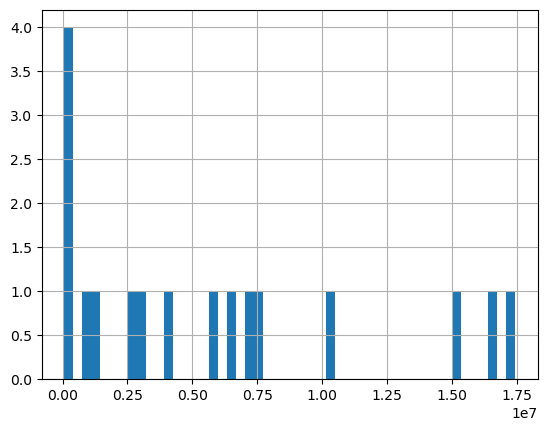

In [143]:
fire_history[~vect_isinstance(fire_history.geometry)].area.hist(bins=50);

In [123]:
pd.Series(
    [
        len(y)
        for y
        in fire_history.years
        if isinstance(y, tuple)
    ] + 
    [
        1
        for y
        in fire_history.years
        if not isinstance(y, tuple)
        ]
    ).value_counts()


1    24
2    17
Name: count, dtype: int64

### Climate data
Now lets get the climate data.  It has already been downloaded and unzipped.

The directory `/media/storage/CBCM` contains California Basin Characterization Model data downloaded from
[https://www.sciencebase.gov/catalog/item/5f29c62d82cef313ed9edb39](https://www.sciencebase.gov/catalog/item/5f29c62d82cef313ed9edb39).  
The following files were downloaded on 2023-09-27 at about 9:40:

	aet_WY1990_99.zip
	aet_WY2000_09.zip
	aet_WY2010_20.zip
	str_WY1990_99.zip
	str_WY2000_09.zip
	str_WY2010_20.zip

and the following files were downloaded 2023-10-17 at about 10:20:

	cwd_WY1990_99.zip
	cwd_WY2000_09.zip
	cwd_WY2010_20.zip

+ Zips were each unzipped into a directory of the same name.
+ The directories were then entered and a directory called `tifs` was created within.
+ The .asc files were then converted to tifs.

Prefixes have the following menings:
 
`aet` : monthly actual evpotranspiration  
`str` : monthly soil storage  
`cwd` : montly climatic water deficit  

Here is an example workflow:
```
mkdir aet_WY2000_09
unzip aet_WY2000_09.zip -d aet_WY2000_09
cd aet_WY2000_09
mkdir tifs
ls *.asc | parallel --progress gdal_translate -of GTiff -co "TILED=YES" -a_srs EPSG:3310 {} tifs/{.}.tif
```

We will once again need to crawl around inside of the directory tree globbing things.


In [7]:
# path to root dir of climate data
cbcm_dir = Path('/media/storage/CBCM')


The dates are present in the file names, which are formatted like so, `aet1993feb.tif`.  We need to change the thee letter month to a number.

In [8]:
# will need for date format
def m2n(m):
    '''changes three letter month ton number'''
    months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    n = months[m]
    return n

Now we can make a big data cube of climate data. Resolution is 270 m, so it should fit in memory.

In [9]:
# open file and reproject as template
template_path = next(cbcm_dir.rglob('aet*.tif'))
template = rioxarray.open_rasterio(template_path).rio.reproject(crs).rio.clip(aoi.geometry.values)

# glob needed files
aet_files = cbcm_dir.rglob('aet*.tif')
str_files = cbcm_dir.rglob('str*.tif')
cwd_files = cbcm_dir.rglob('cwd*.tif')

# stack aet by time
lyrs = []
for aet in list(aet_files):
    # get date
    yyyy = aet.stem.lstrip('aet')[:4]
    m = aet.stem.lstrip('aet')[4:]
    yyyymm = [pd.Period(f'{yyyy}-{m2n(m)}').to_timestamp()]
    
    pre = rioxarray.open_rasterio(aet).squeeze(dim='band')
    lyrs.append(pre.rio.reproject_match(template).expand_dims(time=yyyymm))
aet_temporal_cube = xr.concat(lyrs, dim='time').sortby('time')

# stack str by time
lyrs = []
for str_ in list(str_files):
    # get date
    yyyy = str_.stem.lstrip('str')[:4]
    m = str_.stem.lstrip('str')[4:]
    yyyymm = [pd.Period(f'{yyyy}-{m2n(m)}').to_timestamp()]
    
    pre = rioxarray.open_rasterio(str_).squeeze(dim='band')
    lyrs.append(pre.rio.reproject_match(template).expand_dims(time=yyyymm))
str_temporal_cube = xr.concat(lyrs, dim='time').sortby('time')

# stack cwd by time
lyrs = []
for cwd in list(cwd_files):
    # get date
    yyyy = cwd.stem.lstrip('cwd')[:4]
    m = cwd.stem.lstrip('cwd')[4:]
    yyyymm = [pd.Period(f'{yyyy}-{m2n(m)}').to_timestamp()]
    
    pre = rioxarray.open_rasterio(cwd).squeeze(dim='band')
    lyrs.append(pre.rio.reproject_match(template).expand_dims(time=yyyymm))
cwd_temporal_cube = xr.concat(lyrs, dim='time').sortby('time')

In [10]:
ds = xr.Dataset({
    'AET': aet_temporal_cube,
    'STR': str_temporal_cube,
    'CWD': cwd_temporal_cube
})

In [11]:
ds

<xarray.Dataset>
Dimensions:      (time: 372, x: 366, y: 571)
Coordinates:
  * time         (time) datetime64[ns] 1989-10-01 1989-11-01 ... 2020-09-01
  * x            (x) float64 4.475e+05 4.478e+05 ... 5.46e+05 5.463e+05
  * y            (y) float64 4.58e+06 4.579e+06 ... 4.426e+06 4.425e+06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    AET          (time, y, x) float32 41.12 19.78 40.41 40.52 ... 2.6 28.02 5.81
    STR          (time, y, x) float32 613.9 487.9 696.2 ... 399.4 774.2 404.9
    CWD          (time, y, x) float32 22.58 44.92 23.59 20.98 ... nan nan nan

In [12]:
ds.time

<xarray.DataArray 'time' (time: 372)>
array(['1989-10-01T00:00:00.000000000', '1989-11-01T00:00:00.000000000',
       '1989-12-01T00:00:00.000000000', ..., '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 1989-10-01 1989-11-01 ... 2020-09-01
    band         int64 1
    spatial_ref  int64 0

As can be seen above the datacube  has 372 monthly entries.  Lets save it as a netCDF so we won't have to create it again.

In [13]:
# start and end months
start = ''.join(str(ds.time.min().values).split('-')[:2])
end = ''.join(str(ds.time.max().values).split('-')[:2])

# path to netcdf 
netcdf_path = cbcm_dir / f'cbcm_{start}_{end}.nc'

# save
ds.to_netcdf(netcdf_path)

# PRISM

In [159]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray


# paths
prism_path = Path('/media/storage/PRISM/local_timeseries/PRISM_ppt_tmean_vpdmax_stable_4km_onemonth_200608 202208_40.7842_-123.0241.csv')
annua_path = Path('/media/storage/PRISM/local_timeseries/PRISM_ppt_stable_4km_2006_2022_40.7842_-123.0241.csv')

# open
prism = gpd.read_file(prism_path)
annua = gpd.read_file(annua_path)

In [150]:
prism.head(14)

,PRISM,Time,Series,Data,geometry
0,Location:,,Lat:,40.7842,None
1,"Climate variables: ppt,tmean,vpdmax",NaN,NaN,NaN,None
2,Spatial,resolution:,4km,NaN,None
3,Period:,2006-08,-,2022-08,None
4,Dataset:,AN81m,NaN,NaN,None
5,PRISM,day,definition:,24,None
6,Grid,Cell,Interpolation:,Off,None
7,Time,series,generated:,2023-Nov-16,None
8,Details:,http://www.prism.oregonstate.edu/documents/PRI...,NaN,NaN,None
9,"Date,ppt","(mm),tmean",(degrees,"C),vpdmax",None


In [130]:
prism_header = prism.head(9)
prism_header

,PRISM,Time,Series,Data,geometry
0,Location:,,Lat:,40.7842,None
1,"Climate variables: ppt,tmean,vpdmax",NaN,NaN,NaN,None
2,Spatial,resolution:,4km,NaN,None
3,Period:,2006-08,-,2022-08,None
4,Dataset:,AN81m,NaN,NaN,None
5,PRISM,day,definition:,24,None
6,Grid,Cell,Interpolation:,Off,None
7,Time,series,generated:,2023-Nov-16,None
8,Details:,http://www.prism.oregonstate.edu/documents/PRI...,NaN,NaN,None


['1359.47',
 '716.46',
 '892.61',
 '917.31',
 '1604.44',
 '1001.60',
 '1415.56',
 '358.24',
 '1017.72',
 '742.05',
 '1375.37',
 '1178.34',
 '737.56',
 '1298.20',
 '486.02',
 '942.29',
 '638.80']

In [166]:
cols = ['date', 'annual_precip_mm', 't_aug_mean_C', 'aug_vpdmax']

rows = []
for i in range(10, len(prism)):
    rows.append(np.array((prism.iloc[i].PRISM).split(',')))
    
prism_data = pd.DataFrame(data=np.stack(rows), columns=cols)
prism_data['date'] =  pd.to_datetime(prism_data['date'])
prism_data['annual_precip_mm'] = [x[1] for x in annua[10:].PRISM.str.split(',')]
prism_data['annual_precip_mm'] = prism_data['annual_precip_mm'].astype(float)
prism_data['t_aug_mean_C'] = prism_data['t_aug_mean_C'].astype(float)
prism_data['aug_vpdmax'] = prism_data['aug_vpdmax'].astype(float)
prism_data = prism_data.set_index('date')
prism_data

,annual_precip_mm,t_aug_mean_C,aug_vpdmax
date,,,
2006-08-01,1359.47,21.3,36.79
2007-08-01,716.46,21.5,35.70
2008-08-01,892.61,22.0,38.39
2009-08-01,917.31,21.2,37.88
2010-08-01,1604.44,20.8,34.49
2011-08-01,1001.60,21.5,35.85
2012-08-01,1415.56,23.0,42.36
2013-08-01,358.24,20.8,32.79
2014-08-01,1017.72,22.8,40.12


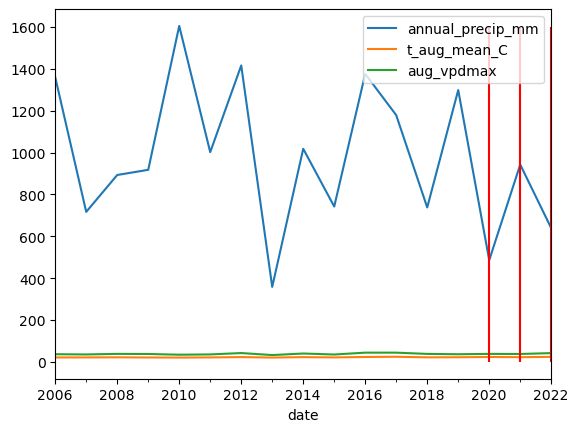

In [169]:
import matplotlib.pyplot as plt
prism_data.plot()
d = prism_data.index.to_list()[-3:]
plt.vlines(d, ymin=0, ymax=1600, colors='r')

In [142]:

def split_data(x):
    return(np.array(x.split(',')))

data = split_data(prism.iloc[10:].PRISM)

ValueError: setting an array element with a sequence

In [133]:
prism_data = prism.tail(len(prism) - 9)
prism_data

,PRISM,Time,Series,Data,geometry
9,"Date,ppt","(mm),tmean",(degrees,"C),vpdmax",None
10,"2006-08,2.09,21.3,36.79",NaN,NaN,NaN,None
11,"2007-08,1.26,21.5,35.70",NaN,NaN,NaN,None
12,"2008-08,0.00,22.0,38.39",NaN,NaN,NaN,None
13,"2009-08,9.45,21.2,37.88",NaN,NaN,NaN,None
14,"2010-08,4.79,20.8,34.49",NaN,NaN,NaN,None
15,"2011-08,0.00,21.5,35.85",NaN,NaN,NaN,None
16,"2012-08,0.00,23.0,42.36",NaN,NaN,NaN,None
17,"2013-08,12.48,20.8,32.79",NaN,NaN,NaN,None
18,"2014-08,0.18,22.8,40.12",NaN,NaN,NaN,None


In [108]:
import numpy as np
import pandas as pd

cwd = []
for t in ds.time:
    cwd.append(ds['CWD'].sel(time=t).values.flatten())
    
cwd = np.stack(cwd)
cols = range(cwd.shape[1])
plt_df = pd.DataFrame(
    data=cwd,
    columns=cols
).set_index(ds['CWD'].indexes['time'].to_datetimeindex())

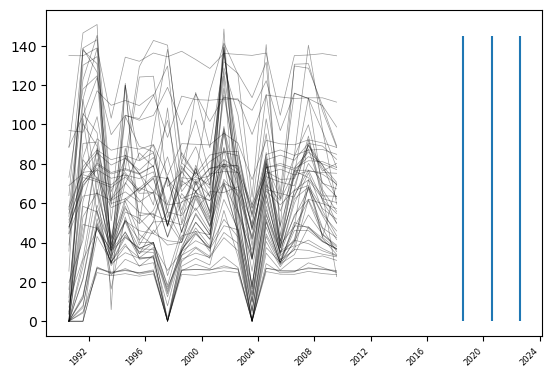

In [120]:
@np.vectorize
def get_month(greg):
    return greg.month

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


ax = plt_df[plt_df >= 0][plt_df.index.month == 8].sample(n=50,axis='columns').plot(
    legend=False,
    lw=0.5,
    color='k',
    alpha=0.4,
    rot=45,
    x_compat=True
    )
plt.xticks(fontsize=6);

plt.vlines([pd.to_datetime(d) for d in ['2018-08-01', '2020-08-01', '2022-08-01']], ymin=0, ymax=145)
#ax.xaxis.set_major_locator(mdates.YearLocator(2, month=8));
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


In [114]:
plt.vlines?

Signature:
plt.vlines(
    x,
    ymin,
    ymax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot vertical lines at each *x* from *ymin* to *ymax*.

Parameters
----------
x : float or array-like
    x-indexes where to plot the lines.

ymin, ymax : float or array-like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have the same length.

colors : list of colors, default: :rc:`lines.color`

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

label : str, default: ''

Returns
-------
`~matplotlib.collections.LineCollection`

Other Parameters
----------------
data : indexable object, optional
    If given, the following parameters also accept a string ``s``, which is
    interpreted as ``data[s]`` (unless this raises an exception):

    *x*, *ymin*, *ymax*, *colors*
**kwargs : `~matplotlib.collections.LineCollection` properties.

See Also
--------
hlines : horizontal lines
a

In [98]:
mdates.DateFormatter?

Init signature: mdates.DateFormatter(fmt, tz=None, *, usetex=None)
Docstring:     
Format a tick (in days since the epoch) with a
`~datetime.datetime.strftime` format string.
Init docstring:
Parameters
----------
fmt : str
    `~datetime.datetime.strftime` format string
tz : str or `~datetime.tzinfo`, default: :rc:`timezone`
    Ticks timezone. If a string, *tz* is passed to `dateutil.tz`.
usetex : bool, default: :rc:`text.usetex`
    To enable/disable the use of TeX's math mode for rendering the
    results of the formatter.
File:           ~/miniconda3/envs/treemort/lib/python3.11/site-packages/matplotlib/dates.py
Type:           type
Subclasses:     